In [32]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, precision_score,classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


In [18]:
df_binary = pd.read_csv("C:/Users/sehsa/ETH/df_binary_model.csv")
df_binary.head()

,sma_binary_2,sma_binary_3,sma_binary_4,sma_binary_5,sma_binary_6,sma_binary_8,sma_binary_12,sma_binary_16,sma_binary_24,sma_binary_10,...,cci_binary_2,cci_binary_3,cci_binary_4,cci_binary_6,cci_binary_8,cci_binary_12,macd_binary,ado_binary,eth_Williams_%R_binary,Target
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,1,1,-1,-1,-1,1
2,1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,-1,1,0
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
4,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,1,1,0


In [3]:
split_index = int(len(df_binary) * 0.8)  # %80 train, %20 test
data_training = df_binary.loc[:split_index - 1, :].copy()   #  %80
data_testing = df_binary.loc[split_index:, :].copy()  #  %20

feature_columns = df_binary.columns.drop('Target')  # 'Target' dışındaki sütunlar özellik
X_train = data_training[feature_columns].values  # Eğitim verisi özellikleri
y_train = data_training['Target'].values  # Eğitim verisi hedef değişkeni
X_test = data_testing[feature_columns].values  # Test verisi özellikleri
y_test = data_testing['Target'].values  # Test verisi hedef değişkeni

# Eğitim verisinin %10'unu doğrulama için ayırma
validation_size = int(len(X_train) * 0.1)  # Eğitim verisinin %10'u doğrulama için
X_val = X_train[-validation_size:]  # Son %10 doğrulama verisi
y_val = y_train[-validation_size:]  # Son %10 hedef değişken
X_train = X_train[:-validation_size]  # İlk %90 eğitim verisi
y_train = y_train[:-validation_size]  # İlk %90 hedef değişken

# Zaman serisi formatına dönüştürme fonksiyonu
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# Zaman penceresi boyutu
window_size = 5

# Eğitim, doğrulama ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

# Dönüştürülen veri şekillerini kontrol etme
X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape

((45471, 5, 42), (45471,), (5047, 5, 42), (5047,), (12627, 5, 42), (12627,))

In [7]:
n = len(df_binary)
df = df_binary.iloc[:n//2]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31580 entries, 0 to 31579
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   sma_binary_2            31580 non-null  int64
 1   sma_binary_3            31580 non-null  int64
 2   sma_binary_4            31580 non-null  int64
 3   sma_binary_5            31580 non-null  int64
 4   sma_binary_6            31580 non-null  int64
 5   sma_binary_8            31580 non-null  int64
 6   sma_binary_12           31580 non-null  int64
 7   sma_binary_16           31580 non-null  int64
 8   sma_binary_24           31580 non-null  int64
 9   sma_binary_10           31580 non-null  int64
 10  sma_binary_48           31580 non-null  int64
 11  wma_binary_9            31580 non-null  int64
 12  wma_binary_2            31580 non-null  int64
 13  wma_binary_3            31580 non-null  int64
 14  wma_binary_4            31580 non-null  int64
 15  wma_binary_6       

In [8]:
split_index = int(len(df) * 0.8)  # %80 train, %20 test
data_training_df = df.loc[:split_index - 1, :].copy()   #  %80
data_testing_df = df.loc[split_index:, :].copy()  #  %20


feature_columns = df.columns.drop('Target')  # 'Target' dışındaki sütunlar özellik
X_train_df = data_training_df[feature_columns].values  # Eğitim verisi özellikleri
y_train_df = data_training_df['Target'].values  # Eğitim verisi hedef değişkeni
X_test_df = data_testing_df[feature_columns].values  # Test verisi özellikleri
y_test_df = data_testing_df['Target'].values  # Test verisi hedef değişkeni


validation_size = int(len(X_train_df) * 0.1)  # Eğitim verisinin %10'u doğrulama için
X_val_df = X_train_df[-validation_size:]  # Son %10 doğrulama verisi
y_val_df = y_train_df[-validation_size:]  # Son %10 hedef değişken
X_train_df = X_train_df[:-validation_size]  # İlk %90 eğitim verisi
y_train_df = y_train_df[:-validation_size]  # İlk %90 hedef değişken


In [9]:

# Girdi verilerini pencereleme fonksiyonu
def create_sequences(data, labels, window_size):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
        sequence_labels.append(labels[i + window_size - 1])
    return np.array(sequences), np.array(sequence_labels)

# Model oluşturma fonksiyonu
def build_and_train_model(params, X_train, y_train, X_val, y_val, model_name):
    model = Sequential()
    model.add(LSTM(
        units=params['lstm_units_1'],
        activation='tanh',
        input_shape=(params['window_size'], X_train.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(params['dropout_1']))
    model.add(LSTM(
        units=params['lstm_units_2'],
        activation='tanh',
        return_sequences=False
    ))
    model.add(Dropout(params['dropout_2']))
    model.add(Dense(params['dense_units'], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=params['learning_rate'], beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Modeli Keras formatında kaydet
    model_path = f"models/{model_name}.keras"  # Keras yerel formatı
    os.makedirs("models", exist_ok=True)  # Klasör oluştur (eğer yoksa)
    model.save(model_path)

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    return val_loss, val_accuracy, model_path

# Hiperparametre aralıklarını tanımlayın
param_grid = {
    'window_size': [5, 10, 20],
    'learning_rate': [0.00005],
    'batch_size': [64],
    'lstm_units_1': [64, 128, 256],
    'lstm_units_2': [64, 128, 256],
    'dense_units': [256],
    'dropout_1': [0.3],
    'dropout_2': [0.4]
}

# Parametre kombinasyonlarını oluştur
param_combinations = list(ParameterGrid(param_grid))

# Performans sonuçlarını saklamak için bir liste
results = []

# Grid Search işlemini başlat
for idx, params in enumerate(param_combinations):
    # Window size'a göre veri oluştur
    X_train_window, y_train_window = create_sequences(X_train_df, y_train_df, params['window_size'])
    X_val_window, y_val_window = create_sequences(X_val_df, y_val_df, params['window_size'])

    # Model adı oluştur
    model_name = f"model_{idx}"

    # Modeli eğit ve doğrulama setindeki performansı değerlendir
    val_loss, val_accuracy, model_path = build_and_train_model(params, X_train_window, y_train_window, X_val_window, y_val_window, model_name)

    # Sonuçları kaydet
    results.append({
        'params': params,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'model_path': model_path
    })
    print(f"Params: {params}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Model Saved: {model_path}")

# En iyi parametre kombinasyonunu seç
best_result = max(results, key=lambda x: x['val_accuracy'])
print(f"En iyi parametreler: {best_result['params']}")
print(f"En iyi doğrulama doğruluğu: {best_result['val_accuracy']:.4f}")
print(f"En iyi model dosya yolu: {best_result['model_path']}")

# En iyi modeli yükleyin
best_model = load_model(best_result['model_path'])

c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: {'batch_size': 64, 'dense_units': 256, 'dropout_1': 0.3, 'dropout_2': 0.4, 'learning_rate': 5e-05, 'lstm_units_1': 64, 'lstm_units_2': 64, 'window_size': 5}, Val Loss: 0.6861, Val Accuracy: 0.5603, Model Saved: models/model_0.keras
Params: {'batch_size': 64, 'dense_units': 256, 'dropout_1': 0.3, 'dropout_2': 0.4, 'learning_rate': 5e-05, 'lstm_units_1': 64, 'lstm_units_2': 64, 'window_size': 10}, Val Loss: 0.6861, Val Accuracy: 0.5590, Model Saved: models/model_1.keras
Params: {'batch_size': 64, 'dense_units': 256, 'dropout_1': 0.3, 'dropout_2': 0.4, 'learning_rate': 5e-05, 'lstm_units_1': 64, 'lstm_units_2': 64, 'window_size': 20}, Val Loss: 0.6875, Val Accuracy: 0.5620, Model Saved: models/model_2.keras
Params: {'batch_size': 64, 'dense_units': 256, 'dropout_1': 0.3, 'dropout_2': 0.4, 'learning_rate': 5e-05, 'lstm_units_1': 64, 'lstm_units_2': 128, 'window_size': 5}, Val Loss: 0.6877, Val Accuracy: 0.5579, Model Saved: models/model_3.keras
Params: {'batch_size': 64, 'dense_uni

In [4]:
# Zaman penceresi boyutu
window_size = 5

# Eğitim, doğrulama ve test verilerini zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

# Model oluşturma
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5032 - loss: 0.6933 - val_accuracy: 0.5257 - val_loss: 0.6920
Epoch 2/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5090 - loss: 0.6927 - val_accuracy: 0.5290 - val_loss: 0.6918
Epoch 3/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5104 - loss: 0.6929 - val_accuracy: 0.5239 - val_loss: 0.6919
Epoch 4/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5172 - loss: 0.6922 - val_accuracy: 0.5241 - val_loss: 0.6918
Epoch 5/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5131 - loss: 0.6925 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 6/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5230 - loss: 0.6922 - val_accuracy: 0.5165 - val_loss: 0.6922
Epoch 7/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5236 - loss: 0.6914 - val_accuracy: 0.5150 - val_loss: 0.6924
Epoch 8/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5167 - loss: 0.6919 - val_accuracy: 0.5177

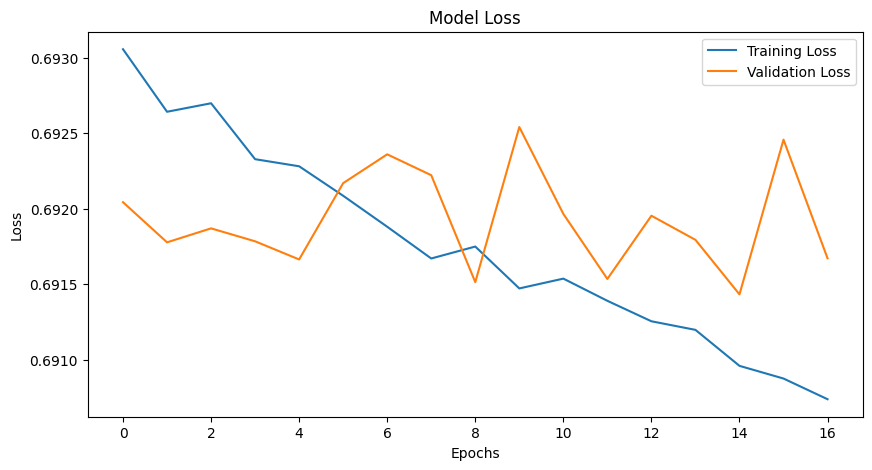

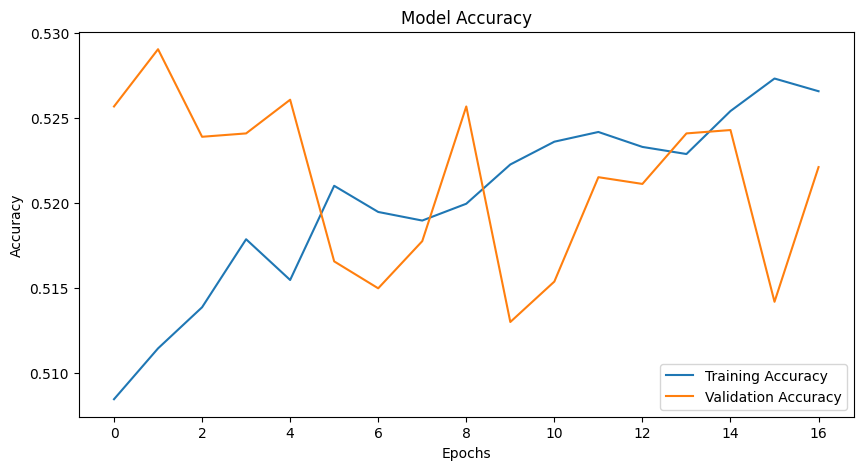

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5225
              precision    recall  f1-score   support

           0       0.52      0.42      0.46      6229
           1       0.52      0.62      0.57      6398

    accuracy                           0.52     12627
   macro avg       0.52      0.52      0.52     12627
weighted avg       0.52      0.52      0.52     12627

ROC-AUC Score: 0.5325


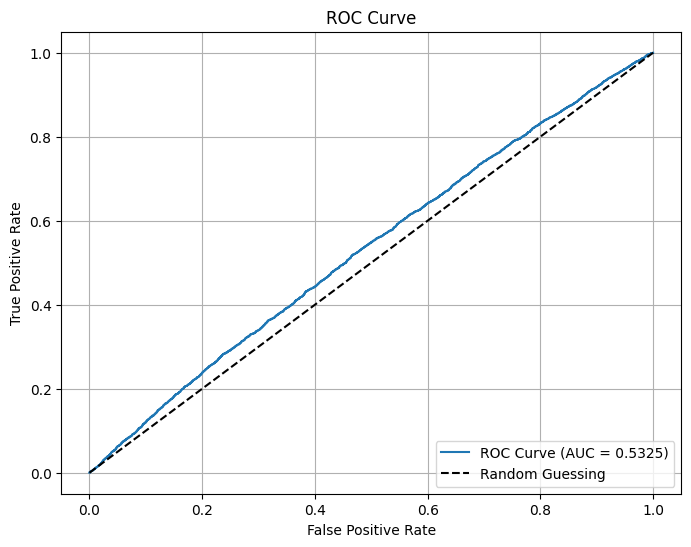

In [ ]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# Test setinin kopyasını oluştur
X_test_seq_copy = np.array(X_test_seq)
y_test_seq_copy = np.array(y_test_seq)

# Temel performansı ölçme
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Base Test Accuracy: {test_accuracy}")

# Permutation Importance
feature_importance = []

# Her bir özellik için işlemi tekrarla
for feature_idx in range(X_test_seq.shape[2]):  # Özellik sayısı
    # Özelliği rastgele karıştır
    X_permuted = np.array(X_test_seq_copy)
    np.random.shuffle(X_permuted[:, :, feature_idx])
    
    # Performansı ölç
    permuted_loss, permuted_accuracy = model.evaluate(X_permuted, y_test_seq_copy, verbose=0)
    
    # Performans farkını kaydet
    accuracy_drop = test_accuracy - permuted_accuracy
    feature_importance.append(accuracy_drop)
    print(f"Feature {feature_idx}: Accuracy Drop = {accuracy_drop}")

# Sonuçları sıralama
feature_importance = np.array(feature_importance)
sorted_indices = np.argsort(-feature_importance)

print("\nFeature Importance Sıralaması:")
for idx in sorted_indices:
    print(f"Feature {idx}: Importance = {feature_importance[idx]}")

Base Test Accuracy: 0.5225310921669006
Feature 0: Accuracy Drop = -7.921457290649414e-05
Feature 1: Accuracy Drop = -0.0021382570266723633
Feature 2: Accuracy Drop = -0.001108705997467041
Feature 3: Accuracy Drop = 0.0009503364562988281
Feature 4: Accuracy Drop = 0.0016630887985229492
Feature 5: Accuracy Drop = 0.0022966861724853516
Feature 6: Accuracy Drop = -0.0016630887985229492
Feature 7: Accuracy Drop = 0.0010295510292053223
Feature 8: Accuracy Drop = -0.0007919669151306152
Feature 9: Accuracy Drop = -0.0011879205703735352
Feature 10: Accuracy Drop = -0.0031678080558776855
Feature 11: Accuracy Drop = -0.0016630887985229492
Feature 12: Accuracy Drop = -0.00047516822814941406
Feature 13: Accuracy Drop = -0.00023758411407470703
Feature 14: Accuracy Drop = -0.0005543828010559082
Feature 15: Accuracy Drop = 7.921457290649414e-05
Feature 16: Accuracy Drop = -0.0019006729125976562
Feature 17: Accuracy Drop = -0.000633537769317627
Feature 18: Accuracy Drop = -0.0011879205703735352
Feature

In [15]:
important_features = [38, 28, 5, 4, 33, 25, 39,19,7,3,40,21]  
X_train_selected = X_train[:, important_features]
X_val_selected = X_val[:, important_features]
X_test_selected = X_test[:, important_features]

# 2. Verileri yeniden zaman serisi formatına dönüştürme
X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train, window_size)
X_val_seq, y_val_seq = create_sequences(X_val_selected, y_val, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test, window_size)

# 3. Modeli yeniden tanımlama
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# 4. Modeli derleme
optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 5. Early stopping ekleme
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# 6. Modeli eğitme
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=150, 
    batch_size=64, 
    validation_data=(X_val_seq, y_val_seq), 
    callbacks=[early_stopping]
)

# 7. Test seti üzerinde modelin değerlendirilmesi
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5022 - loss: 0.6933 - val_accuracy: 0.5215 - val_loss: 0.6921
Epoch 2/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5077 - loss: 0.6929 - val_accuracy: 0.5231 - val_loss: 0.6922
Epoch 3/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5116 - loss: 0.6928 - val_accuracy: 0.5219 - val_loss: 0.6923
Epoch 4/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5117 - loss: 0.6929 - val_accuracy: 0.5193 - val_loss: 0.6924
Epoch 5/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5120 - loss: 0.6925 - val_accuracy: 0.5215 - val_loss: 0.6919
Epoch 6/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5171 - loss: 0.6925 - val_accuracy: 0.5189 - val_loss: 0.6925
Epoch 7/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5112 - loss: 0.6924 - val_accuracy: 0.5197 - val_loss: 0.6923
Epoch 8/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5241 - loss: 0.6918 -

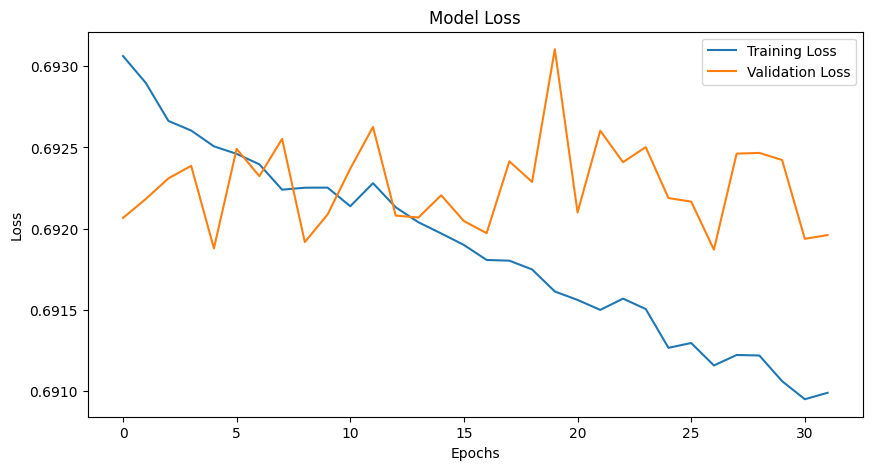

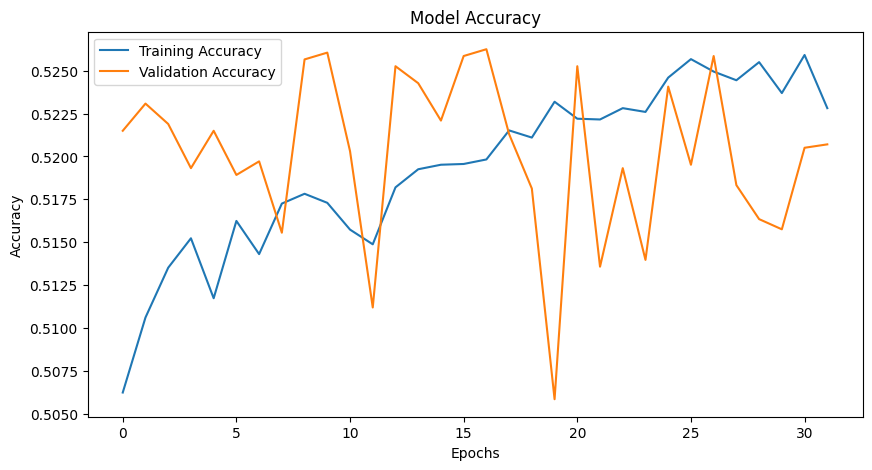

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5239
              precision    recall  f1-score   support

           0       0.52      0.49      0.50      6229
           1       0.53      0.56      0.54      6398

    accuracy                           0.52     12627
   macro avg       0.52      0.52      0.52     12627
weighted avg       0.52      0.52      0.52     12627

ROC-AUC Score: 0.5280


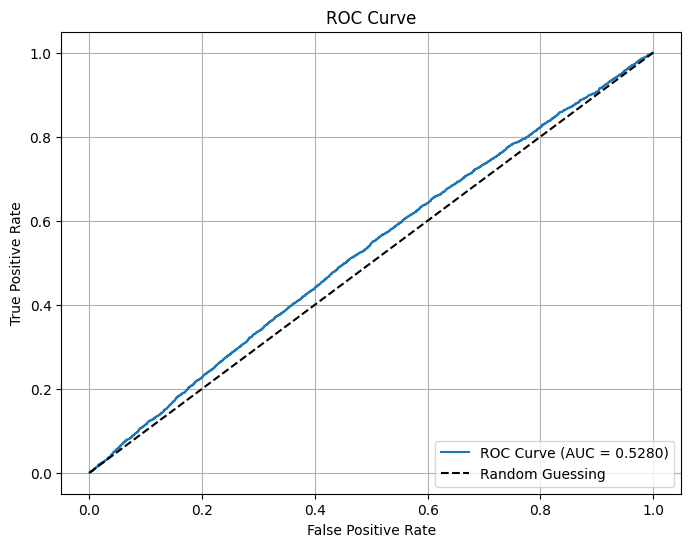

In [16]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


dropout added

In [ ]:
# 3. Modeli yeniden tanımlama
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  

# 4. Modeli derleme
optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 5. Early stopping ekleme
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# 6. Modeli eğitme
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=150, 
    batch_size=64, 
    validation_data=(X_val_seq, y_val_seq), 
    callbacks=[early_stopping]
)

# 7. Test seti üzerinde modelin değerlendirilmesi
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5078 - loss: 0.6931 - val_accuracy: 0.5231 - val_loss: 0.6920
Epoch 2/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5117 - loss: 0.6929 - val_accuracy: 0.5215 - val_loss: 0.6924
Epoch 3/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5119 - loss: 0.6927 - val_accuracy: 0.5197 - val_loss: 0.6922
Epoch 4/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5193 - loss: 0.6922 - val_accuracy: 0.5171 - val_loss: 0.6930
Epoch 5/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5132 - loss: 0.6926 - val_accuracy: 0.5142 - val_loss: 0.6925
Epoch 6/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5117 - loss: 0.6926 - val_accuracy: 0.5231 - val_loss: 0.6922
Epoch 7/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5140 - loss: 0.6924 - val_accuracy: 0.5263 - val_loss: 0.6918
Epoch 8/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5167 - loss: 0.6924 - val_accuracy: 0.

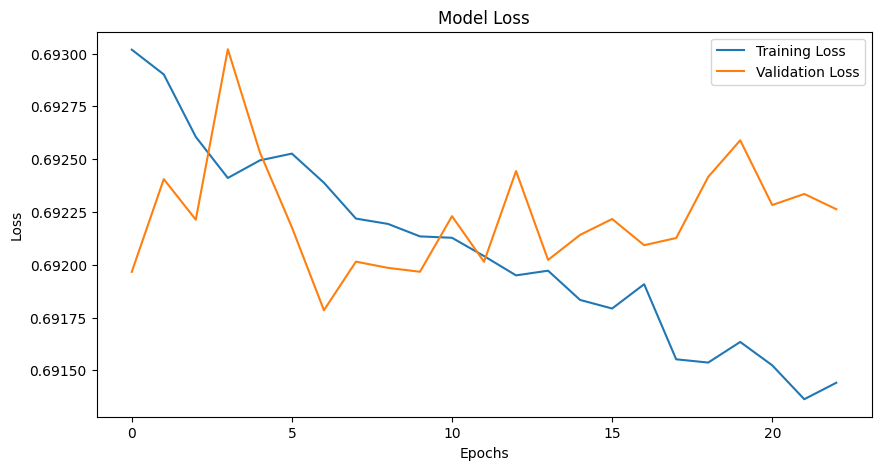

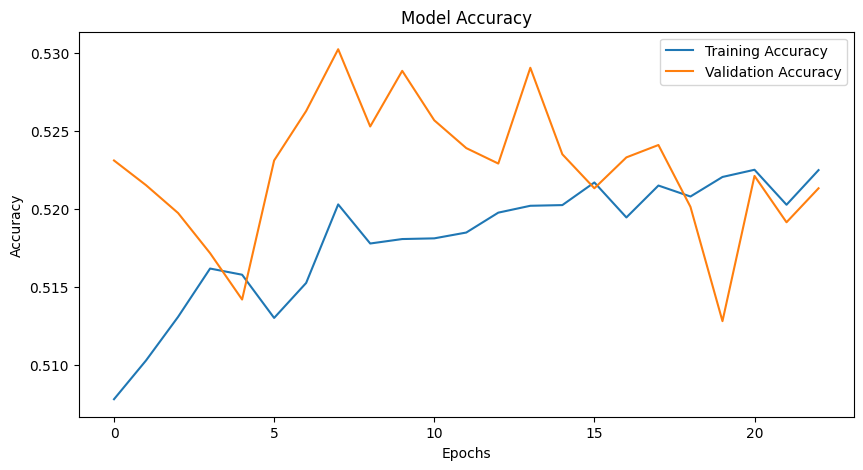

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5234
              precision    recall  f1-score   support

           0       0.52      0.42      0.46      6229
           1       0.52      0.63      0.57      6398

    accuracy                           0.52     12627
   macro avg       0.52      0.52      0.52     12627
weighted avg       0.52      0.52      0.52     12627

ROC-AUC Score: 0.5295


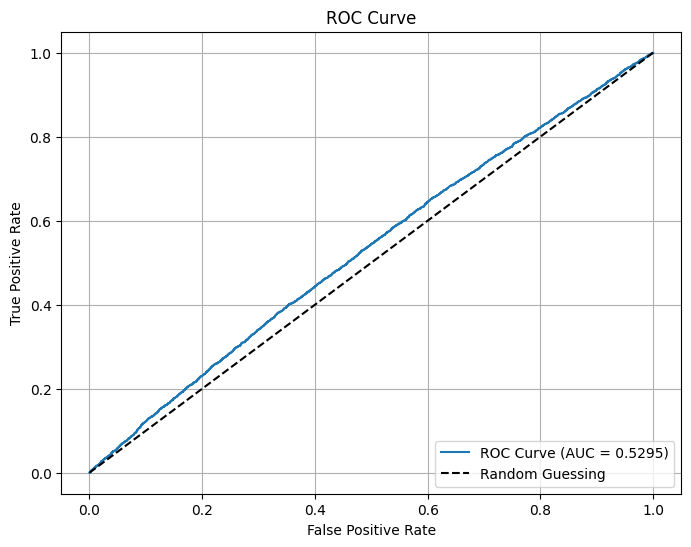

In [21]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [22]:
# Model oluşturma
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(Dropout(0.))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

# Compiling the model
optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


711/711 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5111 - loss: 0.6928 - val_accuracy: 0.4997 - val_loss: 0.6940
Epoch 2/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5141 - loss: 0.6929 - val_accuracy: 0.5213 - val_loss: 0.6924
Epoch 3/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5190 - loss: 0.6922 - val_accuracy: 0.5274 - val_loss: 0.6917
Epoch 4/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5176 - loss: 0.6922 - val_accuracy: 0.5183 - val_loss: 0.6924
Epoch 5/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5211 - loss: 0.6921 - val_accuracy: 0.5197 - val_loss: 0.6926
Epoch 6/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5192 - loss: 0.6920 - val_accuracy: 0.5195 - val_loss: 0.6923
Epoch 7/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5244 - loss: 0.6917 - val_accuracy: 0.5270 - val_loss: 0.6922
Epoch 8/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5186 - loss: 0.6917 - val_

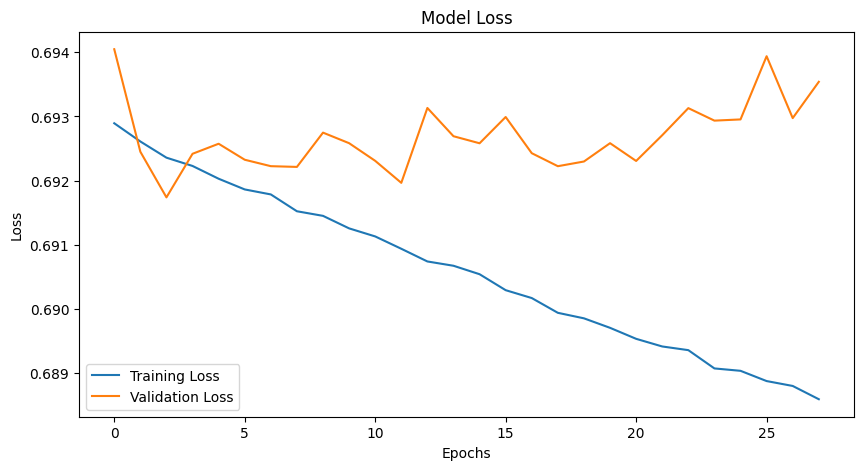

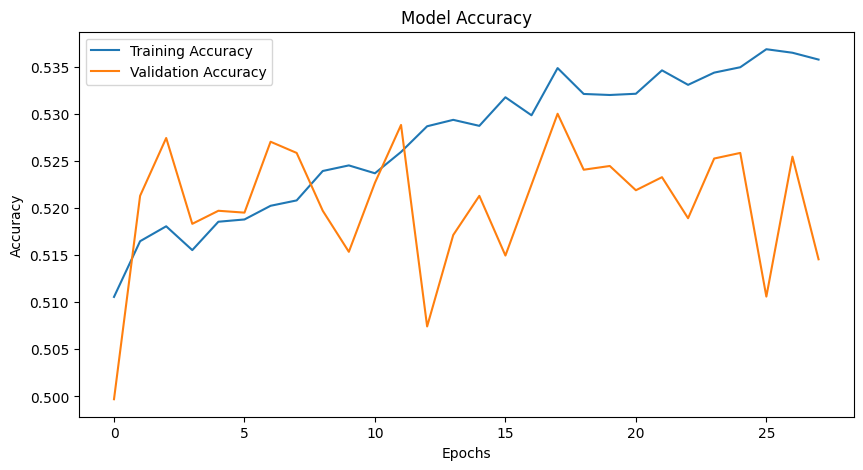

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.5221
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      6229
           1       0.53      0.54      0.53      6398

    accuracy                           0.52     12627
   macro avg       0.52      0.52      0.52     12627
weighted avg       0.52      0.52      0.52     12627

ROC-AUC Score: 0.5258


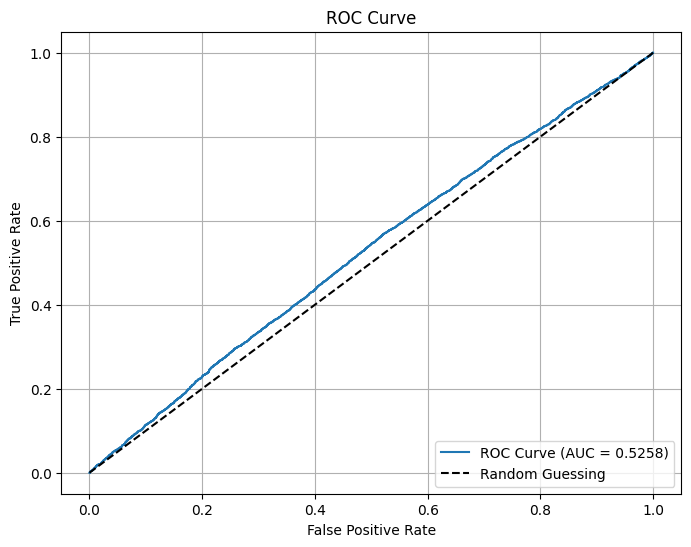

In [23]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [25]:
model = Sequential()

# İlk LSTM Katmanı
model.add(LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# İkinci LSTM Katmanı
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense Katmanı
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# Çıkış Katmanı
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


711/711 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4976 - loss: 0.8175 - val_accuracy: 0.5160 - val_loss: 0.7047
Epoch 2/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5109 - loss: 0.7309 - val_accuracy: 0.5183 - val_loss: 0.6980
Epoch 3/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5080 - loss: 0.7179 - val_accuracy: 0.5255 - val_loss: 0.6947
Epoch 4/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5119 - loss: 0.7110 - val_accuracy: 0.5116 - val_loss: 0.6942
Epoch 5/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5150 - loss: 0.7036 - val_accuracy: 0.5146 - val_loss: 0.6962
Epoch 6/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5162 - loss: 0.7006 - val_accuracy: 0.4999 - val_loss: 0.6970
Epoch 7/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5155 - loss: 0.6997 - val_accuracy: 0.5084 - val_loss: 0.6949
Epoch 8/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5177 - loss: 0.6977 - val_

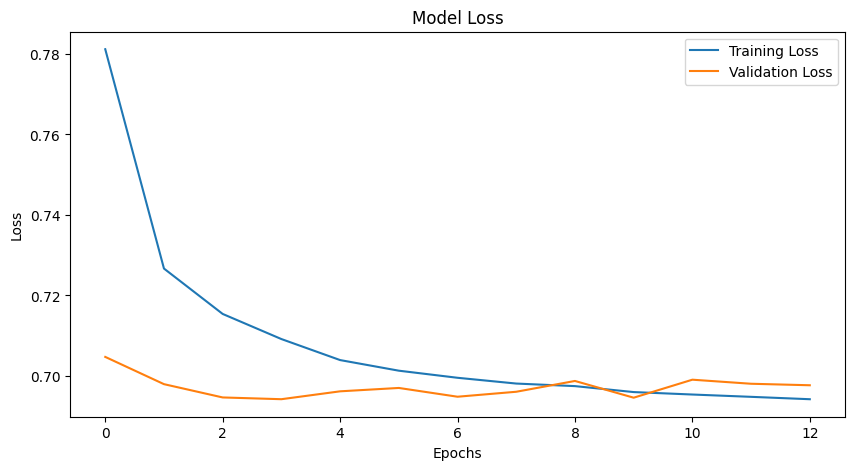

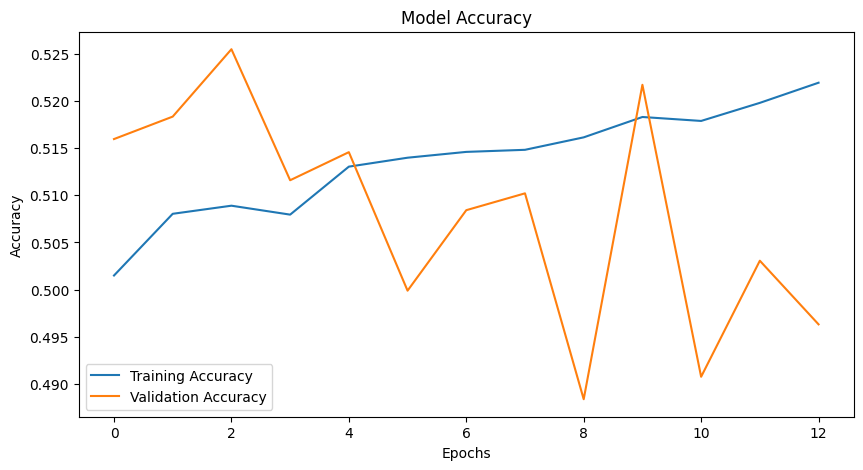

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.5156
              precision    recall  f1-score   support

           0       0.51      0.45      0.48      6229
           1       0.52      0.58      0.55      6398

    accuracy                           0.52     12627
   macro avg       0.51      0.51      0.51     12627
weighted avg       0.52      0.52      0.51     12627

ROC-AUC Score: 0.5187


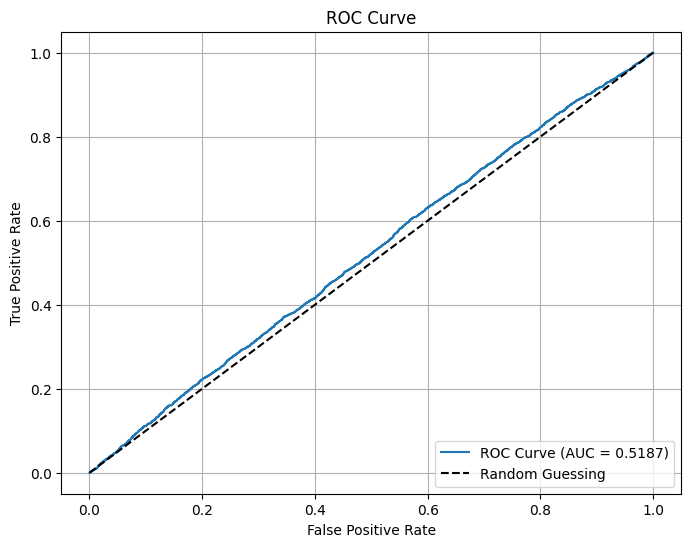

In [26]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [27]:
model = Sequential()

# İlk LSTM Katmanı
model.add(LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# İkinci LSTM Katmanı
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense Katmanı
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# Çıkış Katmanı
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=32, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1421/1421 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.4969 - loss: 0.7909 - val_accuracy: 0.5106 - val_loss: 0.7048
Epoch 2/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5061 - loss: 0.7205 - val_accuracy: 0.5017 - val_loss: 0.6986
Epoch 3/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5073 - loss: 0.7085 - val_accuracy: 0.4965 - val_loss: 0.6999
Epoch 4/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5147 - loss: 0.7024 - val_accuracy: 0.5144 - val_loss: 0.6961
Epoch 5/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5142 - loss: 0.6995 - val_accuracy: 0.4926 - val_loss: 0.6975
Epoch 6/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5161 - loss: 0.6977 - val_accuracy: 0.5013 - val_loss: 0.6974
Epoch 7/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5114 - loss: 0.6974 - val_accuracy: 0.4922 - val_loss: 0.6994
Epoch 8/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5177 - los

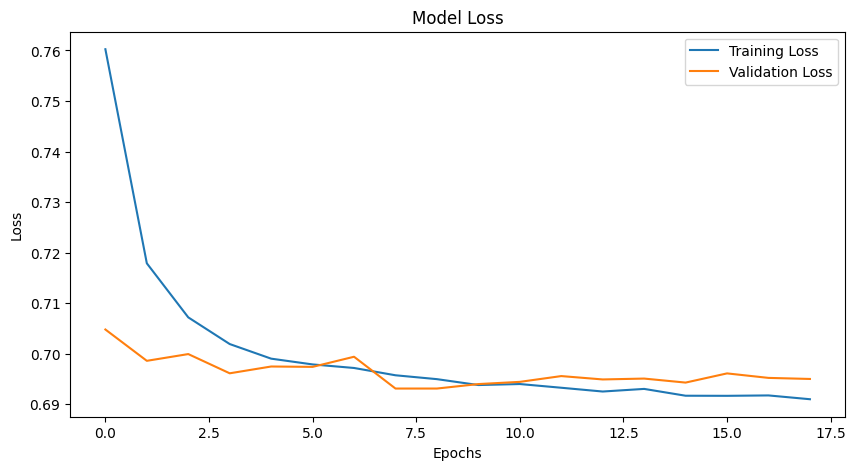

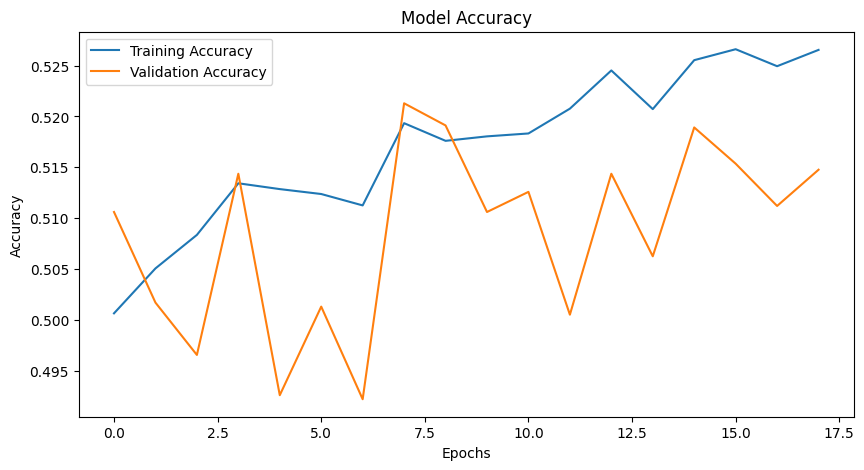

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.5137
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      6229
           1       0.52      0.51      0.52      6398

    accuracy                           0.51     12627
   macro avg       0.51      0.51      0.51     12627
weighted avg       0.51      0.51      0.51     12627

ROC-AUC Score: 0.5184


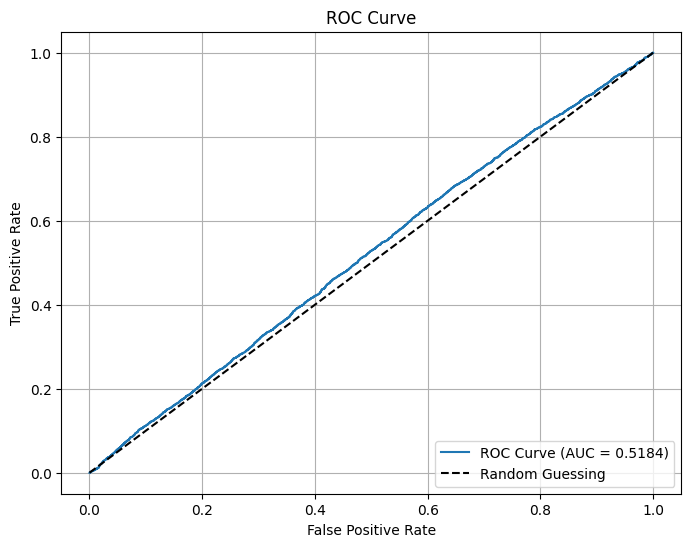

In [28]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [29]:
model = Sequential()

# İlk LSTM Katmanı
model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# İkinci LSTM Katmanı
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Dense Katmanı
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

# Çıkış Katmanı
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5010 - loss: 0.7953 - val_accuracy: 0.4983 - val_loss: 0.7131
Epoch 2/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5081 - loss: 0.7309 - val_accuracy: 0.4991 - val_loss: 0.7103
Epoch 3/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5056 - loss: 0.7179 - val_accuracy: 0.5051 - val_loss: 0.7022
Epoch 4/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4998 - loss: 0.7142 - val_accuracy: 0.5074 - val_loss: 0.6981
Epoch 5/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5065 - loss: 0.7085 - val_accuracy: 0.5066 - val_loss: 0.6980
Epoch 6/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5056 - loss: 0.7048 - val_accuracy: 0.4995 - val_loss: 0.6997
Epoch 7/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5049 - loss: 0.7020 - val_accuracy: 0.4997 - val_loss: 0.6974
Epoch 8/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5121 - loss: 0.7000 - val_accuracy: 0.51

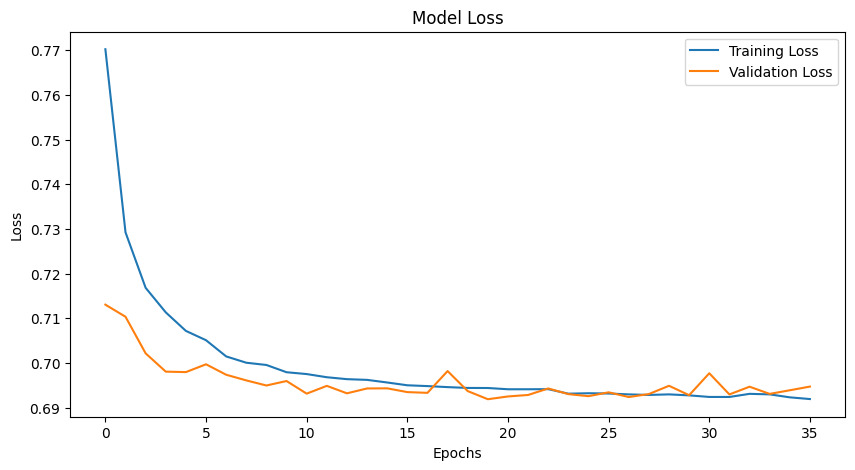

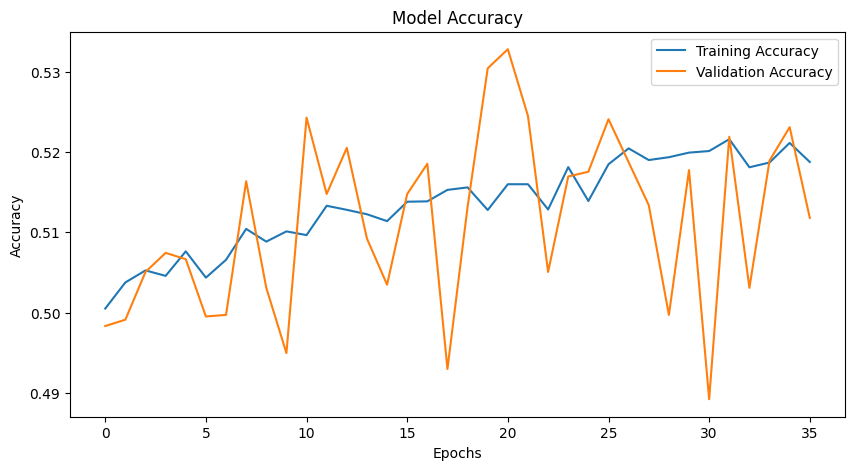

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5164
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      6229
           1       0.52      0.48      0.50      6398

    accuracy                           0.52     12627
   macro avg       0.52      0.52      0.52     12627
weighted avg       0.52      0.52      0.52     12627

ROC-AUC Score: 0.5251


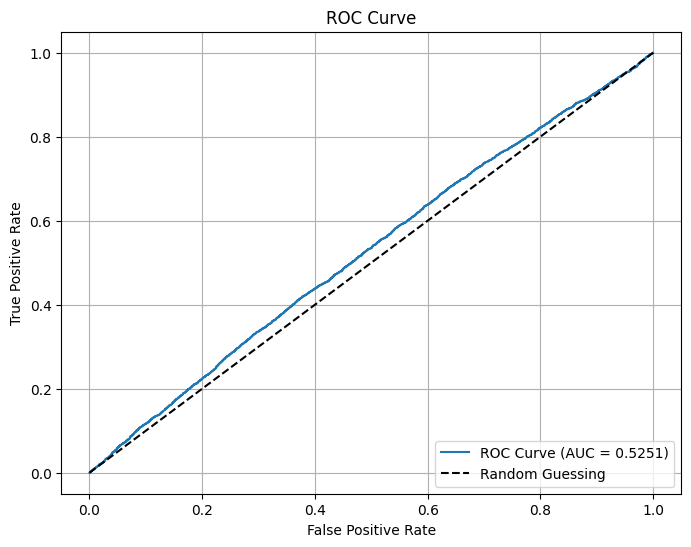

In [30]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [33]:
model = Sequential()

# İlk LSTM Katmanı
model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# İkinci LSTM Katmanı
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Dense Katmanı
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

# Çıkış Katmanı
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5014 - loss: 0.7538 - val_accuracy: 0.5136 - val_loss: 0.7138
Epoch 2/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4978 - loss: 0.7165 - val_accuracy: 0.5193 - val_loss: 0.6989
Epoch 3/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5047 - loss: 0.7143 - val_accuracy: 0.4866 - val_loss: 0.7129
Epoch 4/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5026 - loss: 0.7176 - val_accuracy: 0.4852 - val_loss: 0.7554
Epoch 5/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5023 - loss: 0.7173 - val_accuracy: 0.4951 - val_loss: 0.6994
Epoch 6/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4971 - loss: 0.7170 - val_accuracy: 0.5165 - val_loss: 0.6955
Epoch 7/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4982 - loss: 0.7127 - val_accuracy: 0.4805 - val_loss: 0.7179
Epoch 8/150
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5030 - loss: 0.7188 -

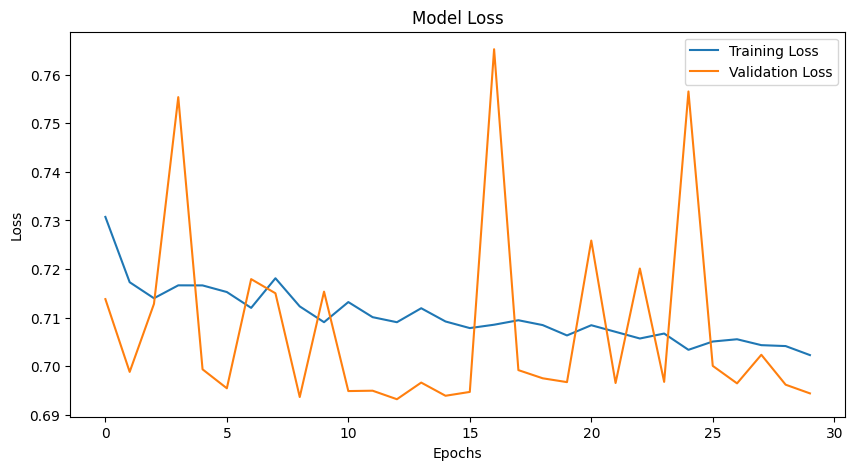

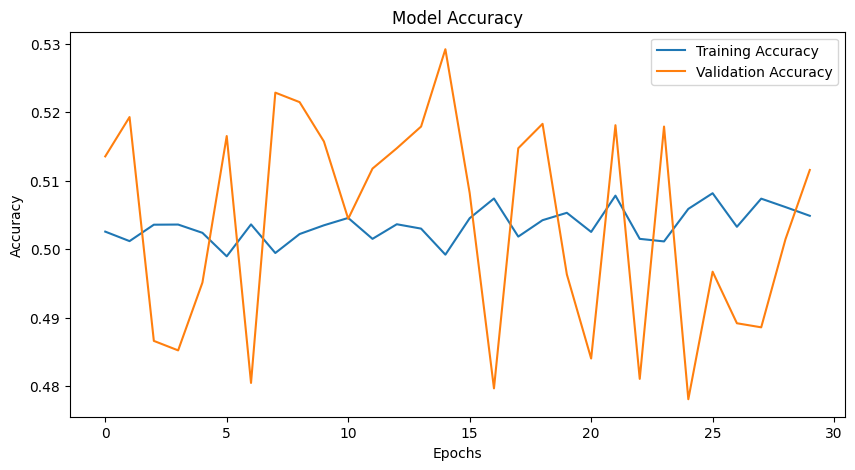

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.5183
              precision    recall  f1-score   support

           0       0.52      0.36      0.43      6229
           1       0.52      0.67      0.59      6398

    accuracy                           0.52     12627
   macro avg       0.52      0.52      0.51     12627
weighted avg       0.52      0.52      0.51     12627

ROC-AUC Score: 0.5200


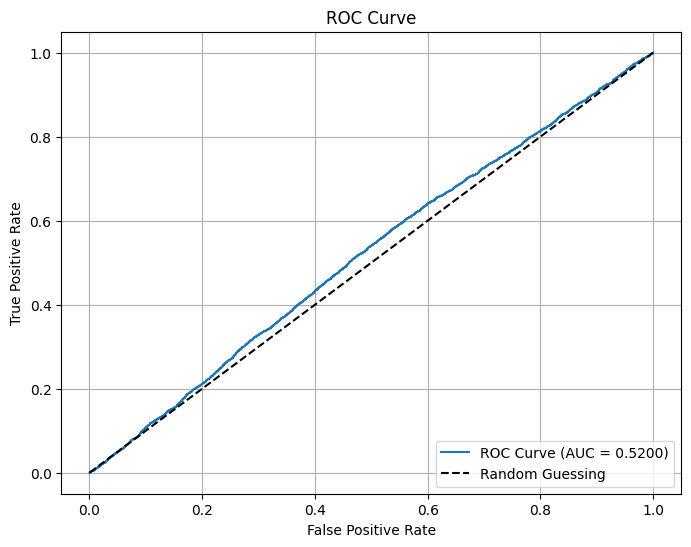

In [34]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [36]:
model = Sequential()

# İlk LSTM Katmanı
model.add(LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# İkinci LSTM Katmanı
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense Katmanı
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# Çıkış Katmanı
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=32, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.5010 - loss: 0.7363 - val_accuracy: 0.5282 - val_loss: 0.7141
Epoch 2/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5002 - loss: 0.7158 - val_accuracy: 0.4936 - val_loss: 0.6973
Epoch 3/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4981 - loss: 0.7110 - val_accuracy: 0.5003 - val_loss: 0.6948
Epoch 4/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5062 - loss: 0.7094 - val_accuracy: 0.5207 - val_loss: 0.6947
Epoch 5/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5081 - loss: 0.7081 - val_accuracy: 0.4821 - val_loss: 0.7150
Epoch 6/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5083 - loss: 0.7059 - val_accuracy: 0.5023 - val_loss: 0.7012
Epoch 7/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5062 - loss: 0.7043 - val_accuracy: 0.5235 - val_loss: 0.6963
Epoch 8/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 

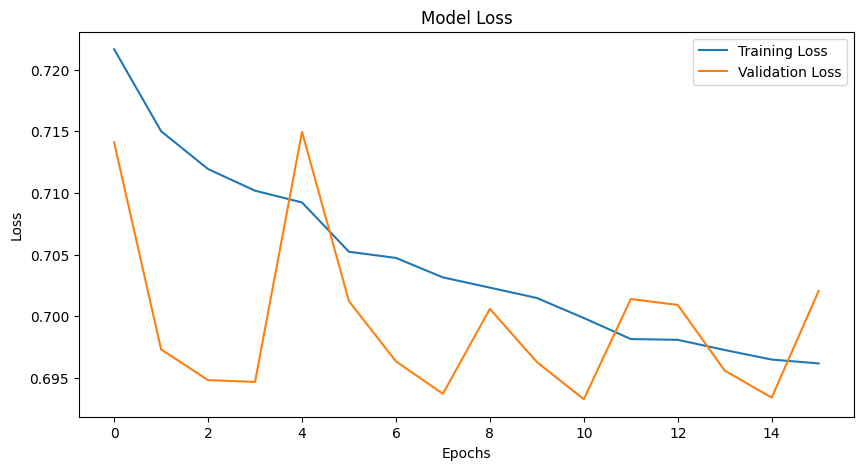

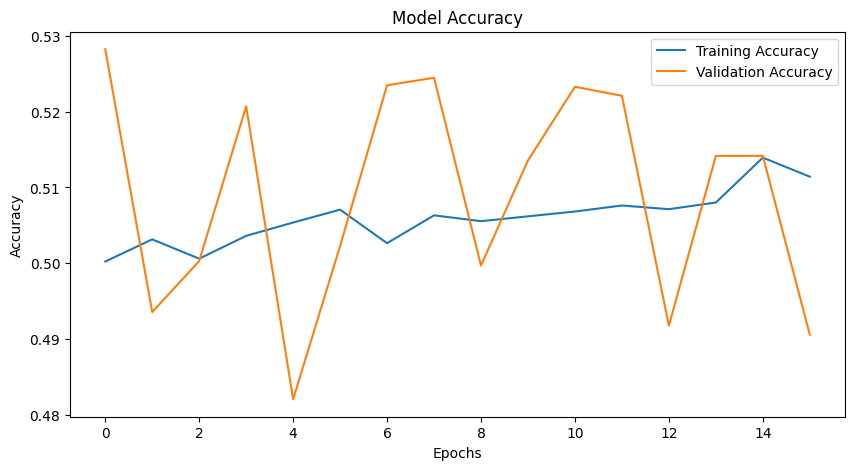

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.5241
              precision    recall  f1-score   support

           0       0.52      0.49      0.51      6229
           1       0.53      0.55      0.54      6398

    accuracy                           0.52     12627
   macro avg       0.52      0.52      0.52     12627
weighted avg       0.52      0.52      0.52     12627

ROC-AUC Score: 0.5243


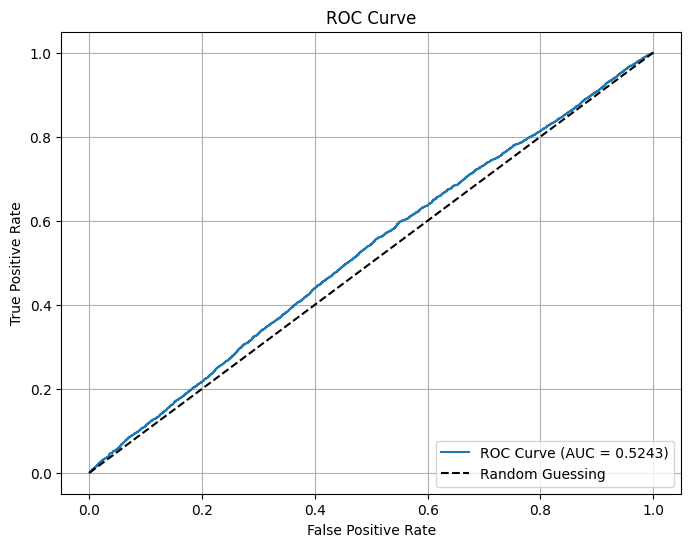

In [37]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [38]:
model = Sequential()

# İlk LSTM Katmanı
model.add(LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# İkinci LSTM Katmanı
model.add(LSTM(256, activation='tanh', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense Katmanı
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# Çıkış Katmanı
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model
history = model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=32, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/150


c:\Users\sehsa\ETH\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1421/1421 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.5060 - loss: 0.7569 - val_accuracy: 0.4926 - val_loss: 0.7017
Epoch 2/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5061 - loss: 0.6996 - val_accuracy: 0.5128 - val_loss: 0.6944
Epoch 3/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5100 - loss: 0.6964 - val_accuracy: 0.5245 - val_loss: 0.6924
Epoch 4/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5096 - loss: 0.6957 - val_accuracy: 0.5058 - val_loss: 0.6935
Epoch 5/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5155 - loss: 0.6942 - val_accuracy: 0.4910 - val_loss: 0.6955
Epoch 6/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5096 - loss: 0.6948 - val_accuracy: 0.4940 - val_loss: 0.6953
Epoch 7/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5053 - loss: 0.6951 - val_accuracy: 0.4932 - val_loss: 0.6968
Epoch 8/150
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5131 - los

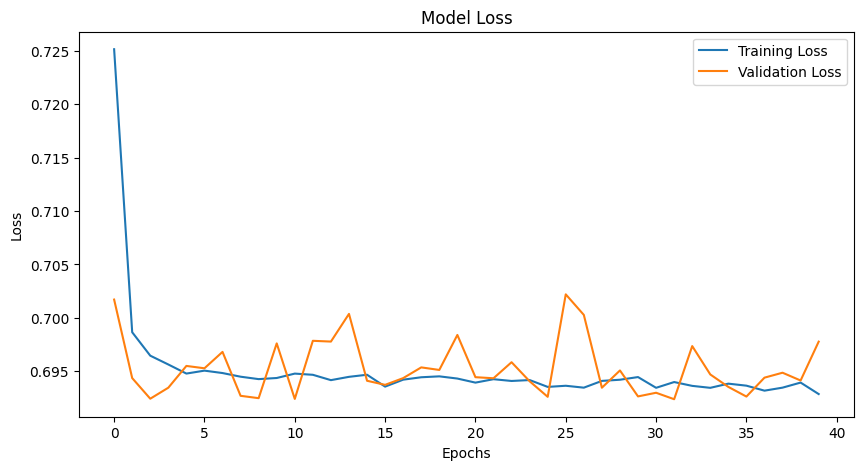

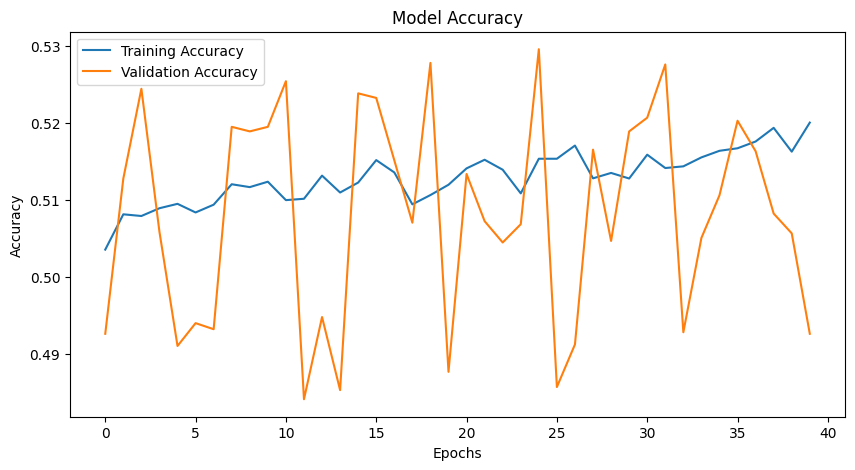

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Accuracy: 0.5185
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      6229
           1       0.52      0.54      0.53      6398

    accuracy                           0.52     12627
   macro avg       0.52      0.52      0.52     12627
weighted avg       0.52      0.52      0.52     12627

ROC-AUC Score: 0.5218


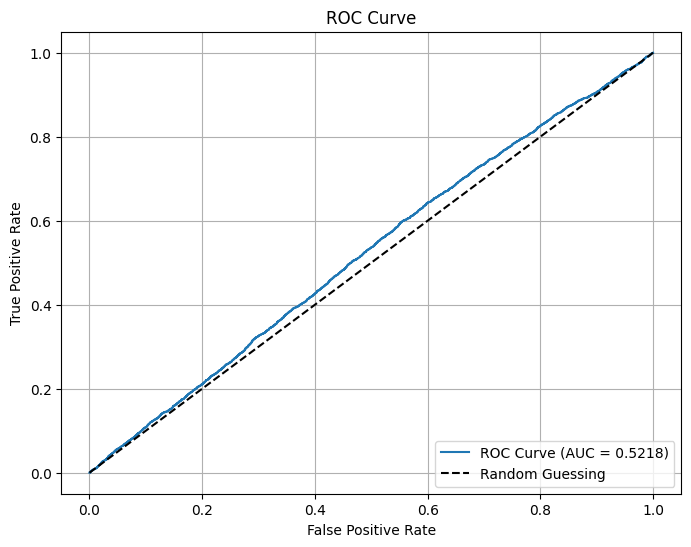

In [39]:
# Visualising training results
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_seq).flatten()  # Tahmin edilen olasılıklar (1D yap)
y_pred = (y_pred_prob > 0.50).astype(int)  # 0.5 eşik değerine göre sınıflandırma

# Değerlendirme Metrikleri
accuracy = accuracy_score(y_test_seq, y_pred)
roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
report = classification_report (y_test_seq, y_pred)

# Sonuçları Yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(report)
print(f"ROC-AUC Score: {roc_auc:.4f}")
# ROC Eğrisi Çizimi

fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
